# **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!nvidia-smi

Sat Nov 26 10:45:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Install**

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install soundfile #windows
!pip install sox #linux

In [ ]:
!pip install librosa

# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines
import torchaudio.functional as AF

from torch.nn.utils.rnn import pad_sequence

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import librosa
from tqdm import tqdm

from IPython.display import Audio

In [ ]:
str(torchaudio.get_audio_backend())

'sox_io'

In [ ]:
print(torch.__version__)
print(torchaudio.__version__)

1.12.1+cu113
0.12.1+cu113


# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

# **Load Audio** 🎵

In [ ]:
!cp -r /content/drive/MyDrive/deep-learning-2022-howsam/session-12-audio/audio_sampels /content/audio_samples

In [ ]:
Audio('/content/audio_samples/steam.wav')

### info

In [ ]:
metadata = torchaudio.info('/content/audio_samples/steam.wav')
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


### load

Sample Rate: 44100
Shape: (2, 109368)
Dtype: torch.float32
 - Max:      0.508
 - Min:     -0.449
 - Mean:     0.000
 - Std Dev:  0.118

tensor([[ 0.0027,  0.0063,  0.0092,  ...,  0.0032,  0.0047,  0.0052],
        [-0.0038, -0.0015,  0.0013,  ..., -0.0032, -0.0012, -0.0003]])



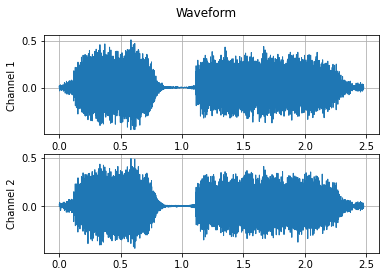

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/steam.wav')
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

Sample Rate: 44100
Shape: (1, 109368)
Dtype: torch.float32
 - Max:      0.499
 - Min:     -0.432
 - Mean:     0.000
 - Std Dev:  0.117

tensor([[-0.0005,  0.0024,  0.0053,  ...,  0.0000,  0.0018,  0.0024]])



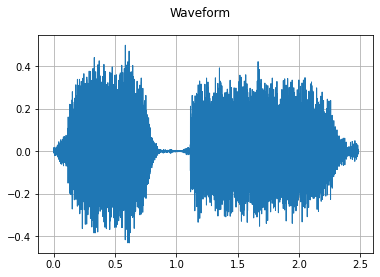

In [ ]:
waveform2 = waveform.mean(dim=0, keepdim=True)
print_stats(waveform2, sample_rate)
plot_waveform(waveform2, sample_rate)
Audio(waveform2.numpy(), rate=sample_rate)

Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



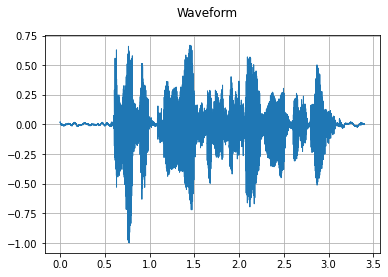

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/speech.wav')
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

Sample Rate: 16000
Shape: (1, 20000)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:    -0.000
 - Std Dev:  0.157

tensor([[ 0.1955,  0.2959,  0.3401,  ..., -0.0397, -0.0335, -0.0283]])



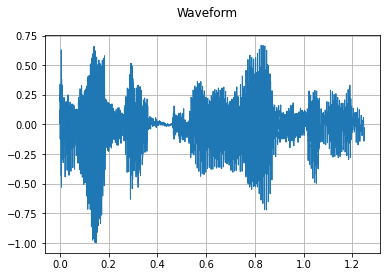

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/speech.wav',
                                        num_frames=20000,
                                        frame_offset=10000)
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

Sample Rate: 16000
Shape: (1, 20000)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:    -0.000
 - Std Dev:  0.157

tensor([[ 0.1955,  0.2959,  0.3401,  ..., -0.0397, -0.0335, -0.0283]])



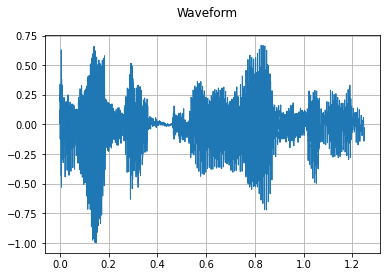

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/speech.wav')
waveform = waveform[:, 10000:30000]
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

### save

In [ ]:
torchaudio.save('/content/audio_samples/speech-trim.wav',
                waveform,
                sample_rate)

# **Transform (is not mandatory) ✂**

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/speech.wav')

## Feature Extraction

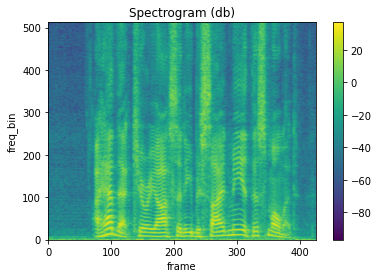

In [ ]:
spectrogram = T.Spectrogram(n_fft=1024, hop_length=128)
spec = spectrogram(waveform)
plot_spectrogram(spec[0])

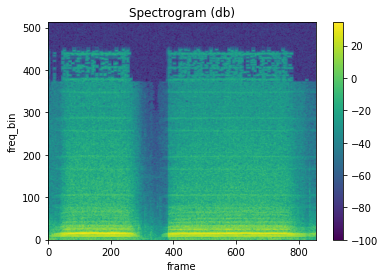

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/steam.wav')
spec = spectrogram(waveform)
plot_spectrogram(spec[0])

In [ ]:
T.InverseSpectrogram()
T.MelSpectrogram()

More details and examples: [link](https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html) [link](https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html)

## Augmentation (not mandatory)

In [ ]:
freq_mask = T.FrequencyMasking(freq_mask_param=200)

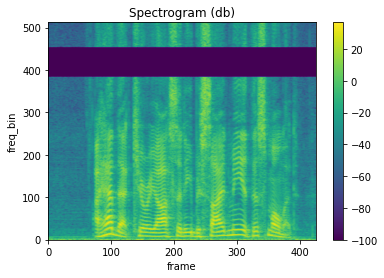

In [ ]:
masked = freq_mask(spec)
plot_spectrogram(masked[0])

In [ ]:
time_mask = T.TimeMasking(time_mask_param=200)

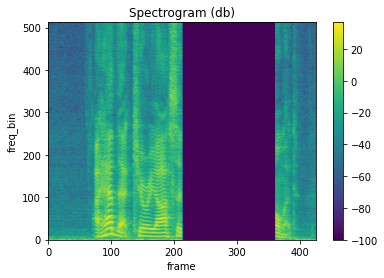

In [ ]:
masked = time_mask(spec)
plot_spectrogram(masked[0])

In [ ]:
T.TimeStretch()

More details and examples: [link](https://pytorch.org/audio/stable/tutorials/audio_feature_augmentation_tutorial.html)

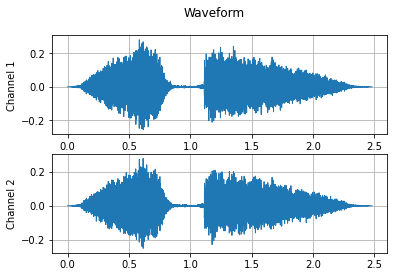

In [ ]:
waveform, sample_rate = torchaudio.load('/content/audio_samples/steam.wav')
fade = T.Fade(fade_in_len=sample_rate, fade_out_len=2*sample_rate)
waveform = fade(waveform)
# waveform[sample_rate:sample_rate+20000] = 0.
plot_waveform(waveform, sample_rate)
Audio(waveform.numpy(), rate=sample_rate)

## Sequential

In [ ]:
transform = nn.Sequential(T.MelSpectrogram(sample_rate=sample_rate, n_mels=32),
                          T.FrequencyMasking(4))

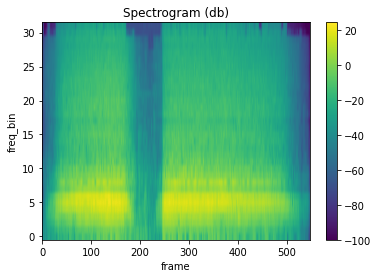

In [ ]:
transformed = transform(waveform)
plot_spectrogram(transformed[1])

## Utils

In [ ]:
Audio(waveform.numpy(), rate=sample_rate)

In [ ]:
resample = T.Resample(orig_freq=sample_rate, new_freq=8000)
waveform2 = resample(waveform)
Audio(waveform2.numpy(), rate=8000)

## Functional

In [ ]:
import torchaudio.functional as AF
AF.spectrogram()
AF.resample()

# **Dataset 🗂️**

In [ ]:
train_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='training')
valid_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='validation')
test_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='testing')

In [ ]:
len(train_set), len(valid_set), len(test_set)

(84843, 9981, 11005)

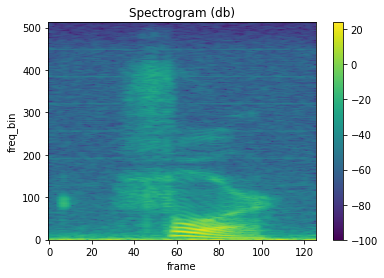

In [ ]:
sample = train_set[20000]
spec = spectrogram(sample[0])
plot_spectrogram(spec[0])
Audio(sample[0], rate=sample[1])

In [ ]:
labels = set([d[2] for d in valid_set])
label2num = {label:num for num, label in enumerate(labels)}
print(label2num)
label2num['cat']

{'down': 0, 'cat': 1, 'nine': 2, 'dog': 3, 'zero': 4, 'two': 5, 'six': 6, 'bed': 7, 'seven': 8, 'house': 9, 'no': 10, 'bird': 11, 'stop': 12, 'sheila': 13, 'follow': 14, 'wow': 15, 'three': 16, 'yes': 17, 'off': 18, 'happy': 19, 'on': 20, 'tree': 21, 'forward': 22, 'eight': 23, 'left': 24, 'five': 25, 'four': 26, 'right': 27, 'backward': 28, 'visual': 29, 'marvin': 30, 'up': 31, 'one': 32, 'go': 33, 'learn': 34}


In [ ]:
def collate_fn(batch):
  data = [b[0][0] for b in batch]
  data = pad_sequence(data, batch_first=True)
  labels = torch.LongTensor([label2num[b[2]] for b in batch])
  return data, labels

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
x, y = next(iter(train_loader))
x.shape, y

(torch.Size([32, 16000]),
 tensor([26, 24, 31, 18,  2, 10, 25, 33,  9, 30, 19, 23, 19,  8,  8,  9, 17, 10,
          8,  5, 20,  8, 15, 27,  8,  4, 10, 16, 18, 24, 23, 10]))

# **Model 🧠**

## Define Model

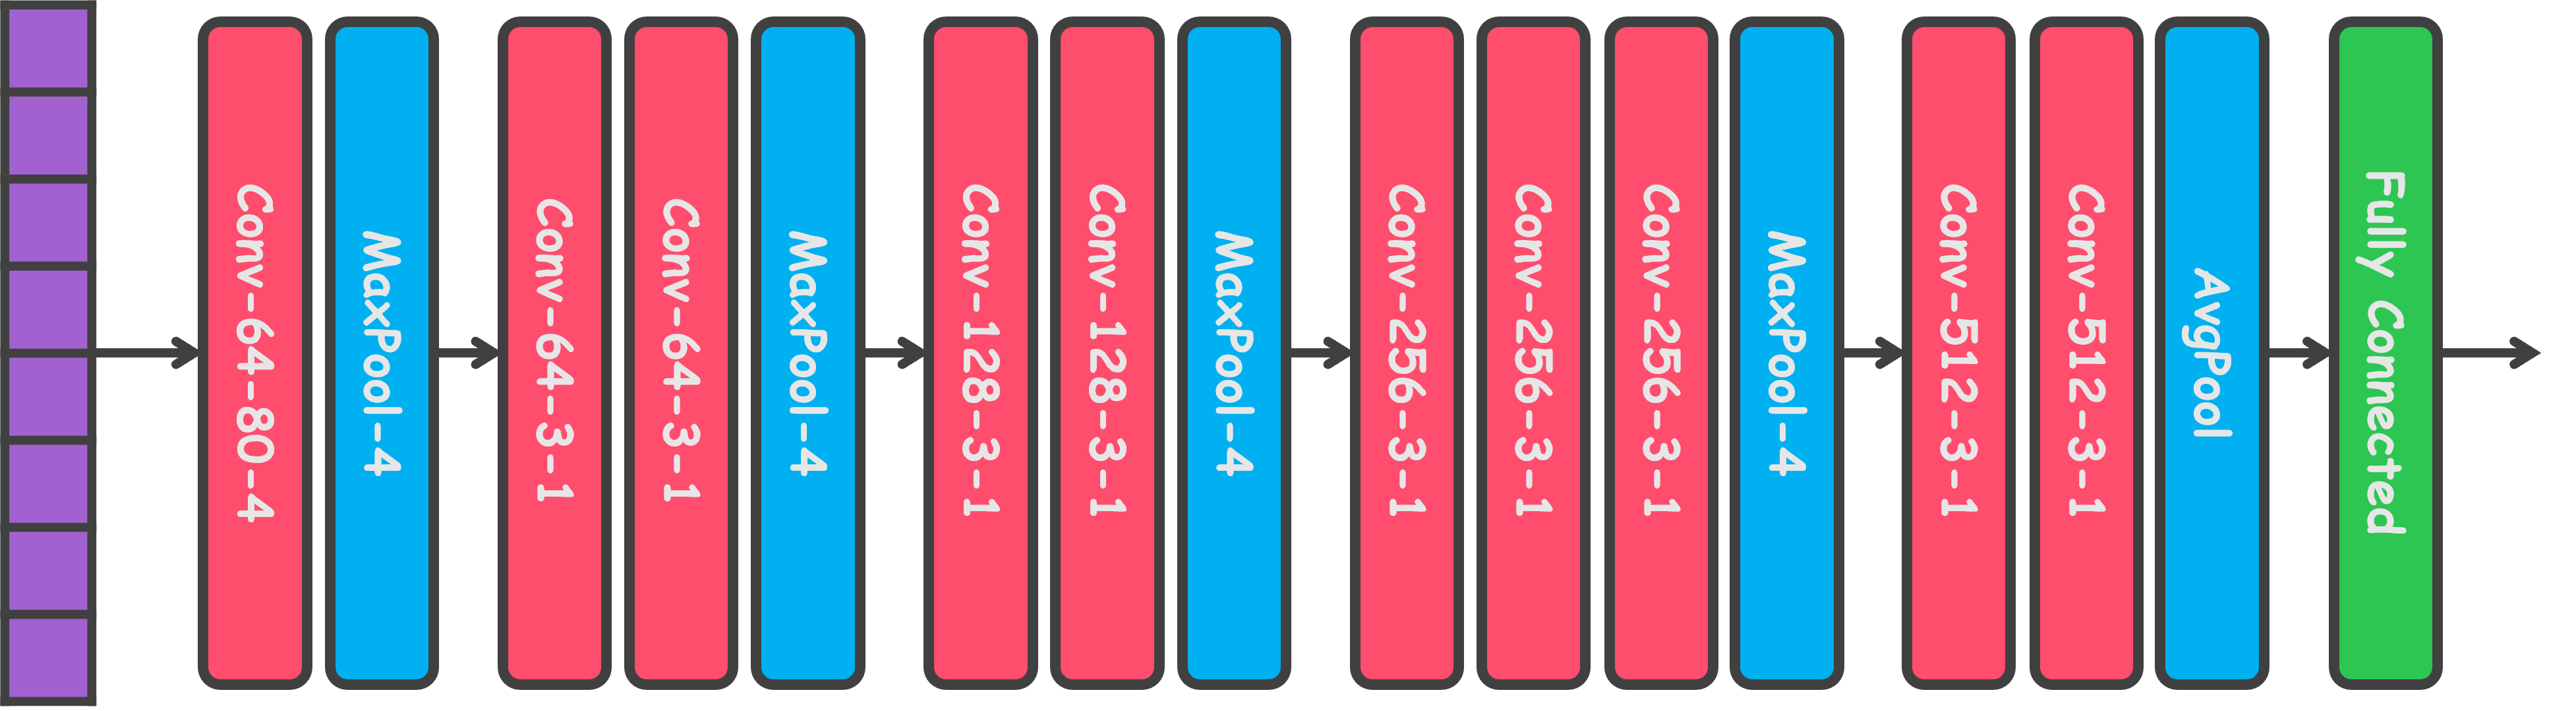

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = M5(n_input=1, n_output=35)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:
num_params(model)

0.026915

## Pretrained Model

In [ ]:
bundle = pipelines.WAV2VEC2_BASE
bundle

Wav2Vec2Bundle(_path='wav2vec2_fairseq_base_ls960.pth', _params={'extractor_mode': 'group_norm', 'extractor_conv_layer_config': [(512, 10, 5), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 2, 2), (512, 2, 2)], 'extractor_conv_bias': False, 'encoder_embed_dim': 768, 'encoder_projection_dropout': 0.1, 'encoder_pos_conv_kernel': 128, 'encoder_pos_conv_groups': 16, 'encoder_num_layers': 12, 'encoder_num_heads': 12, 'encoder_attention_dropout': 0.1, 'encoder_ff_interm_features': 3072, 'encoder_ff_interm_dropout': 0.0, 'encoder_dropout': 0.1, 'encoder_layer_norm_first': False, 'encoder_layer_drop': 0.05, 'aux_num_out': None}, _sample_rate=16000)

In [ ]:
model = bundle.get_model()
model.to(device)

In [ ]:
model.feature_extractor
model.encoder
model.training

False

In [ ]:
out = model(torch.randn((2, 16000), device=device))
out[0].shape

torch.Size([2, 49, 768])

In [ ]:
class Wav2Vec2Cls(nn.Module):

  def __init__(self, num_cls):
    super().__init__()
    bundle = pipelines.WAV2VEC2_BASE
    self.feature_extractor = bundle.get_model()
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    y = self.feature_extractor(x)
    preds = self.fc(y[0])
    return preds

In [ ]:
model = Wav2Vec2Cls(35)
model.to(device)

In [ ]:
model(torch.randn((2, 16000), device=device))

tensor([[[ 0.2882,  0.2973,  0.0768,  ..., -0.2149,  0.1771,  0.2107],
         [ 0.2917,  0.3143,  0.0693,  ..., -0.2188,  0.1892,  0.2007],
         [ 0.2868,  0.2927,  0.0728,  ..., -0.2196,  0.1637,  0.2007],
         ...,
         [ 0.2997,  0.3028,  0.0696,  ..., -0.2252,  0.1564,  0.2011],
         [ 0.3001,  0.2888,  0.0815,  ..., -0.2183,  0.1571,  0.2108],
         [ 0.3039,  0.2608,  0.0922,  ..., -0.2313,  0.1463,  0.2228]],

        [[ 0.1334,  0.1126,  0.1204,  ..., -0.1972, -0.0812,  0.3017],
         [ 0.1122,  0.0973,  0.1399,  ..., -0.2312, -0.0863,  0.2961],
         [ 0.1319,  0.1547,  0.1163,  ..., -0.2142, -0.0239,  0.2558],
         ...,
         [ 0.1306,  0.1394,  0.1004,  ..., -0.2321, -0.1095,  0.2801],
         [ 0.1019,  0.1594,  0.0624,  ..., -0.1795, -0.1094,  0.2889],
         [ 0.1404,  0.1266,  0.0740,  ..., -0.2445, -0.0665,  0.2858]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
num_params(model)

94.397859

In [ ]:
model.feature_extractor.training
# model.feature_extractor.requires_grad_(True)
model.fc.training

True

# **Speech Command Classification 🎹**

## Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

## Init

In [ ]:
num_cls = 35

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [ ]:
train_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='training')
valid_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='validation')
test_set = datasets.SPEECHCOMMANDS(root='/content/', download=True, subset='testing')

In [ ]:
labels = set([d[2] for d in valid_set])
label2num = {label:num for num, label in enumerate(labels)}
print(label2num)
label2num['cat']

{'three': 0, 'happy': 1, 'eight': 2, 'no': 3, 'down': 4, 'nine': 5, 'two': 6, 'six': 7, 'tree': 8, 'seven': 9, 'sheila': 10, 'backward': 11, 'off': 12, 'forward': 13, 'dog': 14, 'five': 15, 'wow': 16, 'cat': 17, 'follow': 18, 'zero': 19, 'right': 20, 'learn': 21, 'four': 22, 'yes': 23, 'one': 24, 'on': 25, 'house': 26, 'marvin': 27, 'go': 28, 'left': 29, 'bed': 30, 'bird': 31, 'stop': 32, 'up': 33, 'visual': 34}


17

In [ ]:
def collate_fn(batch):
  data = [b[0][0] for b in batch]
  data = pad_sequence(data, batch_first=True)
  data = AF.resample(data, 16000, 8000).unsqueeze(1)
  labels = torch.LongTensor([label2num[b[2]] for b in batch])
  return data, labels

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
x, y = next(iter(train_loader))
x.shape, y

(torch.Size([32, 1, 8000]),
 tensor([11,  7, 12, 22, 32, 29, 20, 20, 32, 20, 15,  8, 19, 18, 10, 23, 26, 29,
         18, 12, 12, 30, 30, 32, 14, 14, 33, 21, 29, 14, 19,  6]))

## Model

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x.squeeze(1)

In [ ]:
model = M5(n_input=1, n_output=num_cls)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

## Functions

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

## Train

### Step 1: check forward path

Calculate loss for one batch

In [ ]:
model = M5(n_input=1, n_output=num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(3.8491, grad_fn=<NllLossBackward0>)


### Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_set,
                                     (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20, collate_fn=collate_fn)

In [ ]:
model = M5(n_input=1, n_output=num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 45.22batch/s, accuracy=100, loss=0.00287]


### Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 1
for lr in [0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = M5(n_input=1, n_output=num_cls).to(device)
  model = torch.load('model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

### Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.05, 0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]:
  for wd in [1e-4, 1e-5, 0.]:
    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

### Step 5: train more epochs

In [ ]:
model = M5(n_input=1, n_output=num_cls).to(device)
model = torch.load('model.pt')

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 2652/2652 [02:50<00:00, 15.58batch/s, accuracy=82.6, loss=0.588]


Model Saved!
Valid: Loss = 0.5683, Acc = 0.8366



Epoch 1: 100%|██████████| 2652/2652 [03:20<00:00, 13.25batch/s, accuracy=84.1, loss=0.534]


Model Saved!
Valid: Loss = 0.5323, Acc = 0.8464



Epoch 2: 100%|██████████| 2652/2652 [02:45<00:00, 16.07batch/s, accuracy=84.6, loss=0.514]


Valid: Loss = 0.5334, Acc = 0.8456



Epoch 3: 100%|██████████| 2652/2652 [02:46<00:00, 15.90batch/s, accuracy=84.9, loss=0.504]


Model Saved!
Valid: Loss = 0.52, Acc = 0.8465



Epoch 4: 100%|██████████| 2652/2652 [03:16<00:00, 13.48batch/s, accuracy=85.2, loss=0.494]


Valid: Loss = 0.5362, Acc = 0.8444



Epoch 5: 100%|██████████| 2652/2652 [02:49<00:00, 15.61batch/s, accuracy=85.2, loss=0.492]


Model Saved!
Valid: Loss = 0.5139, Acc = 0.8514



Epoch 6: 100%|██████████| 2652/2652 [02:46<00:00, 15.89batch/s, accuracy=85.5, loss=0.484]


Valid: Loss = 0.5262, Acc = 0.849



Epoch 7: 100%|██████████| 2652/2652 [03:13<00:00, 13.74batch/s, accuracy=85.5, loss=0.482]


Valid: Loss = 0.5146, Acc = 0.8504



Epoch 8: 100%|██████████| 2652/2652 [03:02<00:00, 14.54batch/s, accuracy=85.6, loss=0.478]


Valid: Loss = 0.5209, Acc = 0.8485



Epoch 9: 100%|██████████| 2652/2652 [02:45<00:00, 16.04batch/s, accuracy=85.4, loss=0.478]


Valid: Loss = 0.5259, Acc = 0.8497



Epoch 10: 100%|██████████| 2652/2652 [02:58<00:00, 14.85batch/s, accuracy=85.6, loss=0.472]


Valid: Loss = 0.527, Acc = 0.8497



Epoch 11: 100%|██████████| 2652/2652 [02:57<00:00, 14.95batch/s, accuracy=85.7, loss=0.474]


Valid: Loss = 0.5195, Acc = 0.8511



Epoch 12: 100%|██████████| 2652/2652 [02:48<00:00, 15.78batch/s, accuracy=85.9, loss=0.468]


Valid: Loss = 0.5199, Acc = 0.8512



Epoch 13: 100%|██████████| 2652/2652 [02:57<00:00, 14.96batch/s, accuracy=85.7, loss=0.472]


Valid: Loss = 0.524, Acc = 0.8491



Epoch 14: 100%|██████████| 2652/2652 [03:12<00:00, 13.77batch/s, accuracy=85.9, loss=0.465]


Valid: Loss = 0.5348, Acc = 0.8433



## Plot

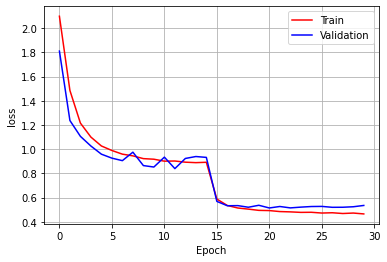

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

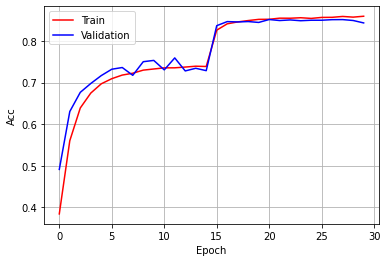

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()